# Predicting Purchase Probabilities

The data we are using is a history of customer purchases in a store for calendar weeks 1 to 49 of the same year for
2000 customers and an assortment of 100 products and we should predict the purchase probability for each customer product pair in week 50. From the perspective of a binary classifier it means: the data given contains only positive examples.

## Exploratory Data Analysis

Let's have a look on these positive examples first.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

In [2]:
df = pd.read_csv("data/train.csv")
(df.shape)
df.head(3)

,customer_id,product_id,price,week
0,0,5,7.03,1
1,0,39,4.71,1
2,0,53,7.61,1


Are there duplicates or NaNs?

In [3]:
print(len(df) - len(df.drop_duplicates()), df.isna().sum().sum())

0 0


All good... Do prices change?

In [4]:
np.mean([(df[df.product_id == i].price.max() - df[df.product_id == i].price.min()) > 0 for i in df.product_id.unique()])

0.0

It's a bit odd. But it looks like prices are constant. It could be that transactions have been successful due to some promotions and we only know reduced prices. On the other hand it might be a matter of data design not to make this problem more complex. Otherwise we would have tried time series forecasting for prices.

How many transactions does each customer within 49 weeks?

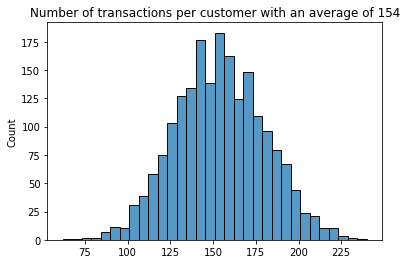

In [5]:
# TODO: (optional) save all following plots with dpi=150 and use Image("graph.png") 
n_transactions_per_customer = [len(df[df.customer_id==i]) for i in df.customer_id.unique()]
sns.histplot(n_transactions_per_customer).set(
    title=f"""Number of transactions per customer with an average of {
        round(np.mean(n_transactions_per_customer))
        }"""
    );plt.show()

In average each customer has roughly 154 transactions (purchases). Data is normally distributed.

How much did each customer spend within 49 weeks?

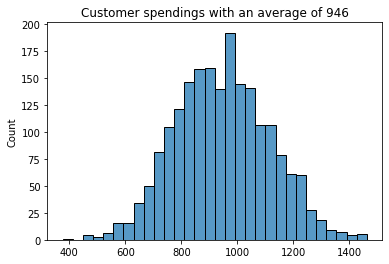

In [6]:
customer_spend = [df[df.customer_id==i].price.sum() for i in df.customer_id.unique()]
sns.histplot(customer_spend).set(
    title=f"""Customer spendings with an average of {
        round(np.mean(customer_spend))
        }"""
    );plt.show()

Similar picture like transactions with an average of 949 EUR spent within 49 weeks.

Did customers go to the store every week?

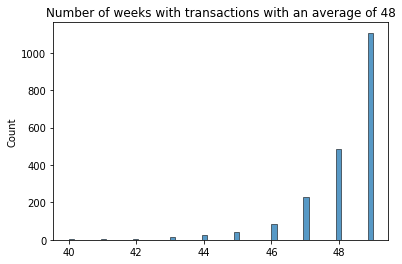

In [7]:
n_weeks_with_transactions = [len(df[df.customer_id==i].groupby(by="week")) for i in df.customer_id.unique()]
sns.histplot(n_weeks_with_transactions).set(
    title=f"""Number of weeks with transactions with an average of {
        round(np.mean(n_weeks_with_transactions))
        }"""
    );plt.show()

It looks like the majority of customers went almost every week to the store (could be me). However, a few didn't come that often. Maybe they live a bit further away or they've been in vacation. We don't know.

How many purchases happened for each product within 49 weeks?

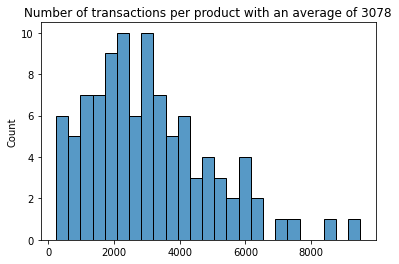

In [8]:
n_transactions_per_product = [len(df[df.product_id==i]) for i in df.product_id.unique()]
sns.histplot(n_transactions_per_product, bins=25).set(
    title=f"""Number of transactions per product with an average of {
        round(np.mean(n_transactions_per_product))
        }"""
    );plt.show()

It looks like the distribution of purchases on product side are a bit right-skewed. A possible explanation might be that some products need to be bought more frequently than others. Imagine a super market. Vegetables you probably want to buy fresh at least once a week, whereas you don't by non-food products like pans that often.

How do returns for ech product look like?

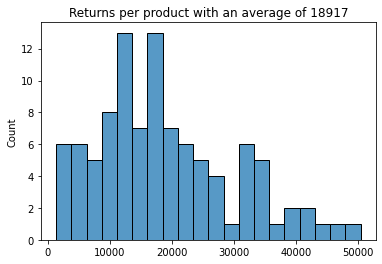

In [9]:
returns_per_product = [df[df.product_id==i].price.sum() for i in df.product_id.unique()]
sns.histplot(returns_per_product, bins=20).set(
    title=f"""Returns per product with an average of {
        round(np.mean(returns_per_product))
        }"""
    );plt.show()

It's a similar picture like with transactions.

How do returns and transactions overall look like for each week?

In [10]:
weekly_returns = df[["week", "price"]].groupby(by="week", as_index=False)["price"].sum().rename(columns={"price":"sum_returns"})
weekly_returns["moving_avg_returns_lm"]=weekly_returns.sum_returns.rolling(4).mean()

# Make it last weeks data
weekly_returns.week = weekly_returns.week + 1
weekly_returns.tail(3)

,week,sum_returns,moving_avg_returns_lm
46,48,38719.42,38790.1400
47,49,39116.56,38964.2075
48,50,38371.94,38849.4225


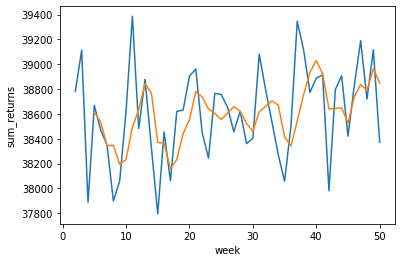

In [11]:
sns.lineplot(x=weekly_returns.week, y=weekly_returns.sum_returns)
sns.lineplot(x=weekly_returns.week, y=weekly_returns.moving_avg_returns_lm)
plt.show()

Turnover goes up and down. And yet, having the general trend and last weeks data might be helpful for predictions, since there is often a strong autocorrelation especially within the first lag of time series.

In [12]:
weekly_transactions = pd.DataFrame({
    "week": list(df["week"].value_counts().index),
    "sum_transactions": df["week"].value_counts().values
})
weekly_transactions.sort_values(by="week",inplace=True)
weekly_transactions["moving_avg_transactions_lm"]=weekly_transactions.sum_transactions.rolling(4).mean()
# Make it last weeks data
weekly_transactions.week = weekly_transactions.week + 1
weekly_transactions.head()

,week,sum_transactions,moving_avg_transactions_lm
11,2,6320,NaN
5,3,6359,NaN
46,4,6175,NaN
26,5,6278,6283.00
37,6,6245,6264.25


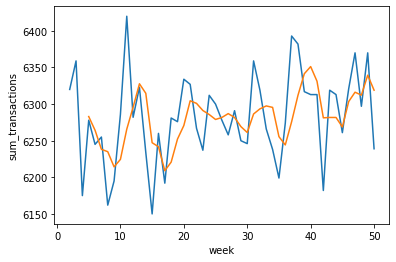

In [13]:
sns.lineplot(x=weekly_transactions.week, y=weekly_transactions.sum_transactions)
sns.lineplot(x=weekly_transactions.week, y=weekly_transactions.moving_avg_transactions_lm)
plt.show()

Basicially same like turnover above... just another scale.

## Feature Engineering

Here we looked at 3 possible sources for feature generation: customers, products, weeks. For *customers and products* we can create static features (constant for each week e.g. `avg_transactions_per_week`) and dynamic features (change every week e.g. `sum_transactions_last_week`). The dynamic features are basically lag-features. The idea is also used in time series problems (1-step-ahead). Data generated for each *week* changes of course. We tried to catch the general movement of the market with it.

Let's get an overview for features generated. Note, more details and comments can be found directly in the script. Please check `utils.py`.

In [14]:
import utils as utils

df_training = utils.create_training_data()
print(df_training.shape)
df_training.head(3)

Computing the cosine similarity matrix...
Done computing similarity matrix.
(9600000, 20)


,label,avg_n_transactions_weekly_customer,avg_spending_weekly,highest_price_paid,lowest_price_paid,pays_above_avg,sum_spending_last_week,n_transactions_last_week_customer,current_price,avg_n_transactions_weekly_product,avg_returns_weekly,costs_above_avg,sum_returns_last_week,n_transactions_last_week_product,sum_returns_last_week_general,moving_avg_returns_lm,sum_transactions_last_week_general,moving_avg_transactions_lm,within_budget,ratings
200000,0,2.489796,15.98551,7.86,4.52,0,25.39,4,5.76,40.285714,232.045714,0,207.36,36,38781.01,38612.5175,6320,6283,1,0.675686
200001,0,2.489796,15.98551,7.86,4.52,0,25.39,4,6.33,44.795918,283.558163,1,303.84,48,38781.01,38612.5175,6320,6283,1,0.605860
200002,0,2.489796,15.98551,7.86,4.52,0,25.39,4,7.81,32.306122,252.310816,1,234.30,30,38781.01,38612.5175,6320,6283,1,0.782352


Successful purchases have the `label` 1. Purchases that did not happen are 0. This is (unfortunately) the majority of all customer-product combinations. So our classes are highly imbalanced.

In [15]:
df_training.label.mean()

0.031408125

Most magic is basically happening in `utils.make_raw_data()` which combines all featues generated. We excluded product_id and customer_id in training data, since these things may change e.g. new products, new customers. However using things like average spending etc may not work well for new customers and/or products. A way to mitigate this might be some scaling over time by always looking at the last month or 2 weeks to build such features. Here we didn't go that far.

In [16]:
help(utils.make_raw_data)

Help on function make_raw_data in module utils:

make_raw_data() -> pandas.core.frame.DataFrame
    Creates a complete data set by combining all methods. In addition it also adds predicted
    user-product ratings as a feature. This function also aligns some data types
    
    Returns
    -------
    pd.DataFrame
        Complete dataset (week 2-50)



Most time was spent on feature engineering. Used models improved from AUC 0.61 to 0.79 max. Let's have a look at correlations.

In [17]:
corr_matrix = df_training.corr().abs().round(3)
display(corr_matrix.style.background_gradient(cmap='coolwarm'))

,label,avg_n_transactions_weekly_customer,avg_spending_weekly,highest_price_paid,lowest_price_paid,pays_above_avg,sum_spending_last_week,n_transactions_last_week_customer,current_price,avg_n_transactions_weekly_product,avg_returns_weekly,costs_above_avg,sum_returns_last_week,n_transactions_last_week_product,sum_returns_last_week_general,moving_avg_returns_lm,sum_transactions_last_week_general,moving_avg_transactions_lm,within_budget,ratings
label,1.000000,0.031000,0.030000,0.004000,0.002000,0.024000,0.007000,0.007000,0.020000,0.109000,0.103000,0.018000,0.101000,0.107000,0.000000,0.000000,0.000000,0.000000,0.048000,0.128000
avg_n_transactions_weekly_customer,0.031000,1.000000,0.970000,0.137000,0.051000,0.782000,0.379000,0.386000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.039000,0.052000
avg_spending_weekly,0.030000,0.970000,1.000000,0.177000,0.020000,0.809000,0.391000,0.375000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.052000
highest_price_paid,0.004000,0.137000,0.177000,1.000000,0.034000,0.153000,0.069000,0.053000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.154000,0.064000
lowest_price_paid,0.002000,0.051000,0.020000,0.034000,1.000000,0.003000,0.008000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.110000,0.059000
pays_above_avg,0.024000,0.782000,0.809000,0.153000,0.003000,1.000000,0.316000,0.302000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033000,0.037000
sum_spending_last_week,0.007000,0.379000,0.391000,0.069000,0.008000,0.316000,1.000000,0.982000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022000,0.010000,0.021000,0.010000,0.016000,0.021000
n_transactions_last_week_customer,0.007000,0.386000,0.375000,0.053000,0.020000,0.302000,0.982000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022000,0.010000,0.022000,0.010000,0.015000,0.021000
current_price,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.186000,0.094000,0.828000,0.092000,0.184000,0.000000,0.000000,0.000000,0.000000,0.133000,0.036000
avg_n_transactions_weekly_product,0.109000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.186000,1.000000,0.945000,0.166000,0.931000,0.986000,0.000000,0.000000,0.000000,0.000000,0.040000,0.782000


There is some multicollinearity to see, mainly due to the fact that they're basicially variations of themselves. And yet they correlate with the target. Each feature contributes the models performance.

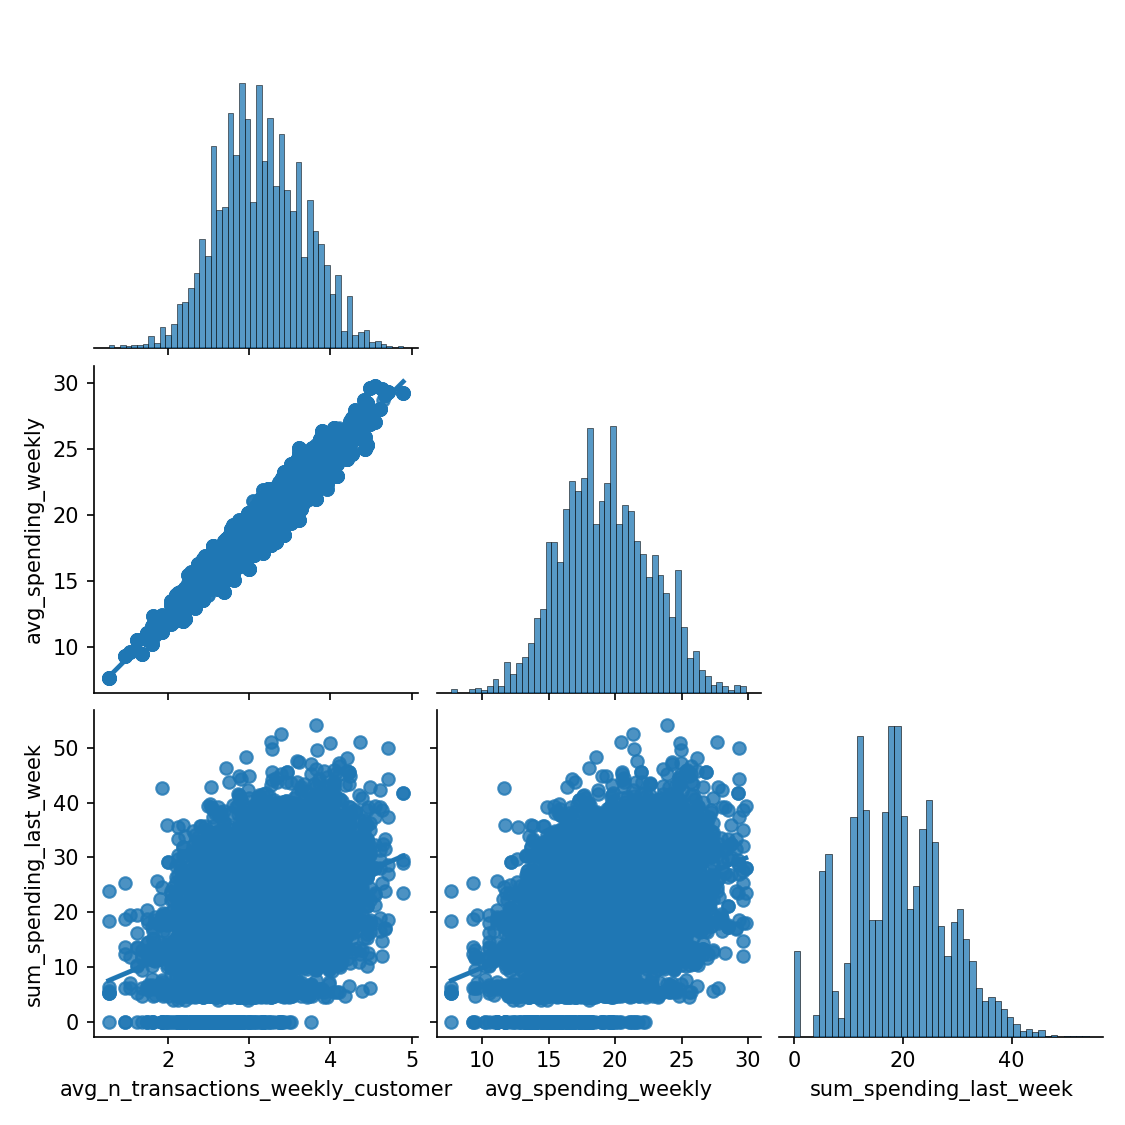

In [27]:
features_small_demo = [
    'avg_n_transactions_weekly_customer', 
    'avg_spending_weekly',
    'sum_spending_last_week'
    ]

sns.pairplot(df_training[features_small_demo].sample(10_000, random_state=1), kind="reg", corner=True)
plt.savefig("img/pairplot_sample.png",dpi=150)
plt.close()
Image("img/pairplot_sample.png", width = 800)

We're just looking on a small sample of features and data here. Many features are normally distributed like their origins. Some features correlate strongly to each other e.g. average spending vs. average transactions.

## Modeling

To predict the probability of a purchase we've built a binary classifier trained on the label described before. 

### Simple Recommender as input
We also used a *collaborative filtering algorithm* with a scaled number of purchases as an equivalent for user-product ratings. These ratings were then used as features for the classifier. In production it would be better to have such a model in a different repo/service. And there you would also train and improve this model. But for now we've just added it to the feature engineering toolbox. If you're interested, we played with this notebook: `recommender_trial.ipynb`.

In [19]:
help(utils.create_ratings)

Help on function create_ratings in module utils:

create_ratings(scaling_factor: int = 5) -> pandas.core.frame.DataFrame
    Creates user-product ratings predicted with a rudimentary recommender model.
    
    Parameters
    ----------
    scaling_factor : int, optional
        factor used during Min-Max-Normalization (make it look like ratings), by default 5
    
    Returns
    -------
    pd.DataFrame
        A dataframe containing "customer_id", "product_id" and corresponding "ratings"



### Classifier

These *ratings* serve as an input feature for the classifier. To iterate fast we've used the low code framework pycaret since it compares different models, cross-validates and plots them with a few lines of code. But please don't use pycaret in production 😉. In production write your own code. It's easier to customize. Important findings are described here. But if you want to see detailed code instead of snippets, please check `modeling_clf.ipynb`.

Trained on only a fraction of 500,000 rows *imbalanced data*, we received an AUC of 0.76 for the CatBoost classifier.
```python
# Train & Compare some models
include = ["catboost", "nb"]

best_models = compare_models(
    sort="AUC",
    include=include, 
    n_select=len(include)
)
```

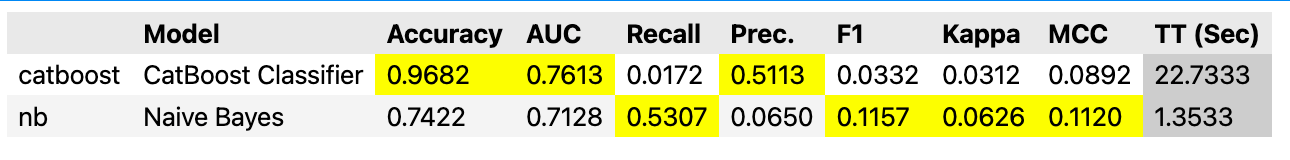

In [28]:
Image("img/imbalanced_metrics.png", width=800)

The ROC curve shows predictions better than random.

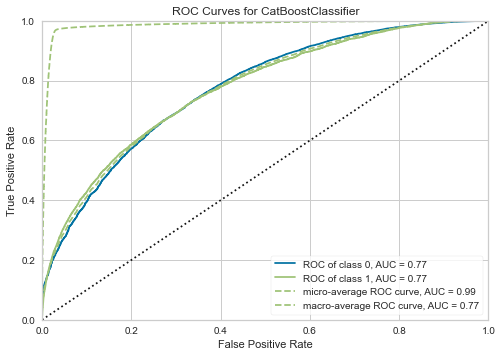

In [29]:
Image("img/imbalanced_roc.png", width=800)

Checking feature importance shows we weren't that wrong by using 'user ratings'. Price and budget also played a role.

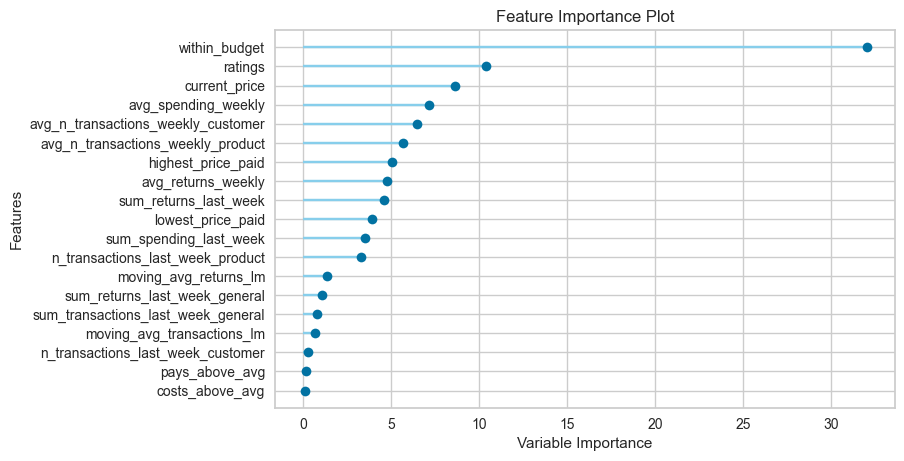

In [30]:
Image("img/imbalanced_feature_importance.png", width=800)

Since our data is highly imbalanced, we tried random undersampling. We wanted to have the positive class a share of only 10% not to create another bias. If your interested in details, please check `sampling.ipynb`. It looks like the metrics improved.

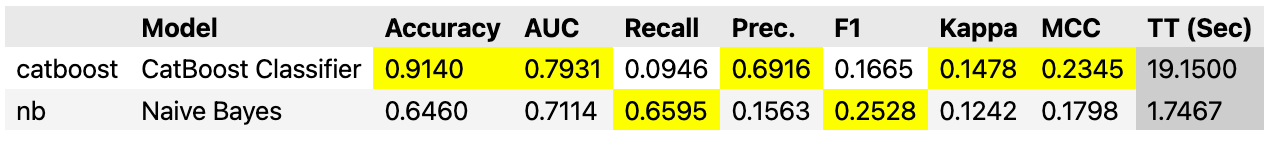

In [31]:
Image("img/resampled_metrics.png", width=800)

AUC went up to 0.79 (catboost)! Also precision seems ok with 0.69. So those identified as positive, are mostly positive. And yet since precision is low, you'd also have many false negatives. But all this would matter more if you'd like to have label (1,0). Then you might look at the calibration and you could also try to optimize thresholds by F-Beta. However, for an untuned model with almost no features given at the first place, the result is ok. 

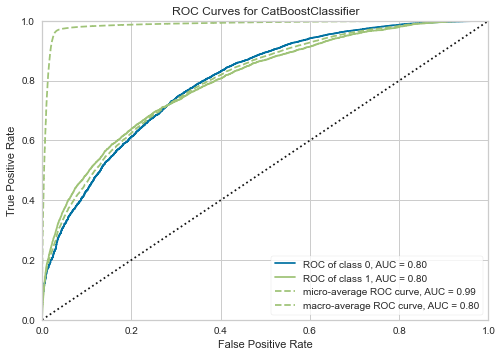

In [32]:
Image("img/resampled_roc.png", width=800)

Even if resampling seemed to have a positive impact, it may have created another bias.
```python
# Check for Bias
for name, model in zip(include, best_models_resampled):
    print(name,
        predict_model(
            estimator=model, 
            data=df_test[df_test.columns[1:]], 
            verbose=False, 
            raw_score=True
            )["Score_1"].mean())

# catboost 0.08147407700000002` 
# nb 0.40262255099999994`
```


## Conclusion

Considering the extreme short amount of time, ending with a performance of AUC 0.79 is not too bad. With *more and better features* one could probably improve the model. Here we didn't even start *hyperparameter optimization, ensembling methods* etc. Just by improving training data the model got better with every iteration ([data centric approach](https://www.forbes.com/sites/gilpress/2021/06/16/andrew-ng-launches-a-campaign-for-data-centric-ai/)). We also didn't *train our model on all 10 mio rows* and used a small fraction of 500,000 rows for each iteration. Considering this amount of data, a neural net may also have a good or better performance here. We also could have created more supporting models e.g. time series forcasts for prices and number of transactions etc. So there's still room for improvement.